In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.models.resnet import BasicBlock
import torch.nn.functional as F

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define the self-supervised contrastive pretraining model architecture
class RotationModel(nn.Module):
    def __init__(self, num_classes):
        super(RotationModel, self).__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification head
        self.projection_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.projection_head(features)

In [4]:
# Define NT-Xent loss function
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, projections_1, projections_2):
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = F.normalize(projections_1, p=2, dim=1)
        projections_2 = F.normalize(projections_2, p=2, dim=1)
        similarities = torch.matmul(projections_1, projections_2.t()) / self.temperature

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = projections_1.size(0)
        contrastive_labels = torch.arange(batch_size, device=projections_1.device)

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = F.cross_entropy(similarities, contrastive_labels)
        loss_2_1 = F.cross_entropy(similarities.t(), contrastive_labels)

        return (loss_1_2 + loss_2_1) / 2

In [5]:
#Transforms
transform=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [6]:
# Instantiate the model
model1 = RotationModel(num_classes=4)  # Assuming 4 rotations (0, 90, 180, 270 degrees)
model1.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


RotationModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [9]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
from torchsummary import summary
summary(model, (3, 150, 150))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [12]:
optimizer=optim.SGD(model1.parameters(),lr=0.1,weight_decay=0.0001)
# Define the loss function and optimizer
criterion = NTXentLoss(temperature=0.2)

In [13]:
# Define number of epochs and folds
num_epochs = 6
num_folds = 5

In [14]:
import torchvision
# Path for training directory
train_path = '/kaggle/input/ssl-png/SSL_png'
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transform)
from torch.utils.data import Subset

In [15]:
from sklearn.model_selection import KFold

In [16]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=64, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=32, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        model1.train()
        running_train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)  # Move input images to the appropriate device
            optimizer.zero_grad()
            outputs = model1(images)
        
            # Generate random rotation angles (1, 2, or 3)
            rotation_angles = torch.randint(1, 4, (len(images),)).to(device)
        
            # Convert rotation angles tensor to integers
            rotation_angles = rotation_angles.tolist()

            # Apply rotation to images
            rotated_images = torch.stack([torch.rot90(image, k, dims=(1, 2)) for image, k in zip(images, rotation_angles)])

            # Forward pass with rotated images
            rotated_outputs = model1(rotated_images)
        
            loss = criterion(outputs, rotated_outputs)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
            
        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # Validation loop
        model1.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model1(images)
                rotation_angles = torch.randint(1, 4, (len(images),)).to(device)
                rotation_angles = rotation_angles.tolist()
                rotated_images = torch.stack([torch.rot90(image, k, dims=(1, 2)) for image, k in zip(images, rotation_angles)])
                rotated_outputs = model1(rotated_images)
                loss = criterion(outputs, rotated_outputs)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
    
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Fold 1/5
Epoch [1/6], Train Loss: 4.0211, Validation Loss: 3.1904
Epoch [2/6], Train Loss: 4.0509, Validation Loss: 3.1887
Epoch [3/6], Train Loss: 3.9530, Validation Loss: 3.0750
Epoch [4/6], Train Loss: 3.4553, Validation Loss: 2.5010
Epoch [5/6], Train Loss: 3.2207, Validation Loss: 2.2120
Epoch [6/6], Train Loss: 3.0896, Validation Loss: 2.1407
Fold 2/5
Epoch [1/6], Train Loss: 2.9132, Validation Loss: 1.8960
Epoch [2/6], Train Loss: 2.8039, Validation Loss: 2.3936
Epoch [3/6], Train Loss: 2.7442, Validation Loss: 2.2456
Epoch [4/6], Train Loss: 2.4858, Validation Loss: 1.5889
Epoch [5/6], Train Loss: 2.2088, Validation Loss: 1.4531
Epoch [6/6], Train Loss: 2.1610, Validation Loss: 1.4460
Fold 3/5
Epoch [1/6], Train Loss: 2.1458, Validation Loss: 1.5164
Epoch [2/6], Train Loss: 2.1967, Validation Loss: 1.3263
Epoch [3/6], Train Loss: 2.1200, Validation Loss: 1.2957
Epoch [4/6], Train Loss: 2.0597, Validation Loss: 1.3728
Epoch [5/6], Train Loss: 2.0924, Validation Loss: 1.4209
Epoc

# >****Fine-Tuning****

In [17]:
# Define the fine-tuning model
class FineTunedModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super(FineTunedModel, self).__init__()
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # Remove the classification head
        
        # Add neural layers for classification
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        with torch.no_grad():  # Freeze backbone weights
            features = self.backbone(x)
        x = F.relu(self.fc1(features))
        x = self.fc2(x)
        return x

# Instantiate the fine-tuned model
fine_tuned_model = FineTunedModel(backbone=RotationModel(num_classes=4).backbone, num_classes=2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
fine_tuned_model.to(device)

FineTunedModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [19]:
optimizer=optim.Adam(fine_tuned_model.parameters(),lr=0.01,weight_decay=0.0001)
# Define BCE loss function
loss_function = nn.CrossEntropyLoss()

In [20]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=16, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        fine_tuned_model.train()
        
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = fine_tuned_model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        
        train_accuracy = train_accuracy / len(train_index)
        train_loss = train_loss / len(train_index)
        
        # Validation loop
        fine_tuned_model.eval()
        
        val_accuracy = 0.0
        val_loss = 0.0
        
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = fine_tuned_model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()* images.size(0)  # Accumulate the loss
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            
        # Compute average loss and accuracy
        val_loss /= len(val_index)
        val_accuracy = val_accuracy / len(val_index)
        
        # Step the scheduler
        # scheduler.step()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        
#         # Save the best model
#         if val_accuracy > best_accuracy:
#             torch.save(fine_tuned_model.state_dict(), 'best_model.pth')
#             best_accuracy = val_accuracy
            
# print(f"Best Validation Accuracy: {best_accuracy}")

Fold 1/5
Epoch [1/6], Train Loss: 2.298, Train Accuracy: 0.523, Val Loss: 0.489, Validation Accuracy: 0.884
Epoch [2/6], Train Loss: 0.998, Train Accuracy: 0.581, Val Loss: 0.903, Validation Accuracy: 0.116
Epoch [3/6], Train Loss: 0.702, Train Accuracy: 0.547, Val Loss: 0.455, Validation Accuracy: 0.884
Epoch [4/6], Train Loss: 0.633, Train Accuracy: 0.663, Val Loss: 0.511, Validation Accuracy: 0.884
Epoch [5/6], Train Loss: 0.640, Train Accuracy: 0.663, Val Loss: 0.534, Validation Accuracy: 0.884
Epoch [6/6], Train Loss: 0.639, Train Accuracy: 0.663, Val Loss: 0.508, Validation Accuracy: 0.884
Fold 2/5
Epoch [1/6], Train Loss: 0.604, Train Accuracy: 0.703, Val Loss: 0.626, Validation Accuracy: 0.721
Epoch [2/6], Train Loss: 0.611, Train Accuracy: 0.703, Val Loss: 0.611, Validation Accuracy: 0.721
Epoch [3/6], Train Loss: 0.606, Train Accuracy: 0.703, Val Loss: 0.600, Validation Accuracy: 0.721
Epoch [4/6], Train Loss: 0.609, Train Accuracy: 0.703, Val Loss: 0.593, Validation Accuracy

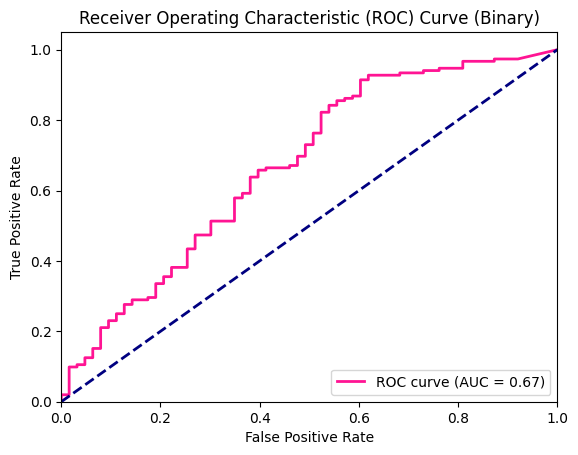

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the test dataset path and transformation
test_path = '/kaggle/input/ssl-png/SSL_png'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)
# Assuming model and test_loader are defined

# Evaluate model
fine_tuned_model.eval()

y_score_list = []
y_true_list = []

for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = fine_tuned_model(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and AUC for class 1
fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
roc_auc = roc_auc_score(y_true_bin, y_score[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Binary)')
plt.legend(loc='lower right')
plt.show()

# 